# Physics-based models (1): what are they?

## The exponential growth of physics-based models articles

Let's fit an exponential curve to the data on number of articles about battery physics-based models per year. The data, which we obtain with a manual search in Google Scholar with the prompt `"physics-based" model "lithium" battery` is:

In [1]:
import numpy as np

years = np.arange(2000, 2023)
articles = np.array([43, 56, 65, 54, 59, 92, 85, 99, 109, 119, 176, 215, 262, 315, 366, 459, 510, 617, 770, 866, 1090, 1520, 1900])

We now use the `curve_fit` method from `scipy.optimize` to fit an exponential curve to the data. First we need to define the curve we want to fit:

In [2]:
def curve(x, a, b):
    return a * np.exp(b * (x - 2000))

And note we shifted the data by `2000` so the problem is better conditioned. Now we can use `curve_fit` to determine the value of the parameters `a` and `b`

In [3]:
from scipy.optimize import curve_fit

parameters, _ = curve_fit(curve, years, articles)
fit = curve(years, *parameters)
print(f'Fit: {parameters[0]:.2f} * exp({parameters[1]:.2f} * (x - 2000))')

Fit: 18.02 * exp(0.21 * (x - 2000))


We finally plot the data and the fit, to produce the figure shown in the blog post.

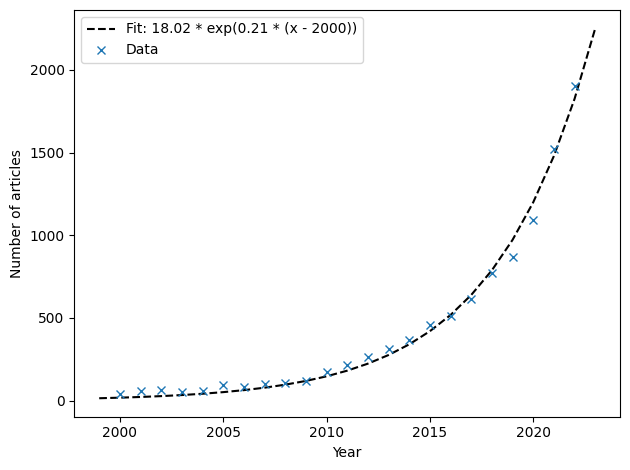

In [4]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1999, 2024), curve(np.arange(1999, 2024), *parameters), 'k--', label=f'Fit: {parameters[0]:.2f} * exp({parameters[1]:.2f} * (x - 2000))')
plt.plot(years, articles, 'x', label='Data')
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.legend()
plt.tight_layout()

# uncomment below to save the figure
# plt.savefig("articles.png", dpi=300)

## Dropping a ball from the top of a tower

We can use PyBaMM to simulate the simple physics-based model used to illustrate the blog post: dropping a ball from the top of a tower. Mathematically, if $x$ is the height of the ball, we can write the model as
$$
    x''(t) = -g, \quad x(0) = x_0, \quad \text{ and } \quad x'(0) = 0,
$$
where $g$ is the acceleration of gravity (in absolute value) and $x_0$ is the initial position of the ball (here $'$ denotes the time derivative). For more details on how the model is defined and solved, you can check the PyBaMM examples [Creating a simple ODE model](https://docs.pybamm.org/en/latest/source/examples/notebooks/creating_models/1-an-ode-model.html) and [ODE solver](https://docs.pybamm.org/en/latest/source/examples/notebooks/solvers/ode-solver.html).

We first define the model:

In [5]:
%pip install pybamm==23.5 -q
import pybamm

# We define the model as a function so we can generate multiple instances of it
def create_model():
    model = pybamm.BaseModel()

    # Define variables to solve for
    x = pybamm.Variable("Position [m]")
    v = pybamm.Variable("Velocity [m.s-1]")

    # Define parameters
    g = pybamm.Parameter("Gravity acceleration [m.s-2]")
    x0 = pybamm.Parameter("Initial position [m]")

    # Define equations and initial conditions
    model.rhs = {x: v, v: -g}
    model.initial_conditions = {x: x0, v: 0}

    # Define event (collision with ground)
    model.events.append(pybamm.Event("Collision with ground", x))

    # Define output variables (to plot)
    model.variables = {
        "Position [m]": x,
        "Velocity [m.s-1]": v,
        "Acceleration [m.s-2]": -g,
    }

    return model


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Now we can generate, process, and solve the model.

In [6]:
model = create_model()

param = pybamm.ParameterValues(
    {
        "Gravity acceleration [m.s-2]": 9.81,
        "Initial position [m]": 100,
    }
)

param.process_model(model)
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model, remove_independent_variables_from_rhs=False)
solver = pybamm.ScipySolver()
t_eval = np.linspace(0, 5, 100)
solution = solver.solve(model, t_eval)

We can use PyBaMM's plotting functionality to easy plot the solution.

In [7]:
solution.plot(["Position [m]", "Velocity [m.s-1]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=4.5152327782515345, step=0.04515232778251534…

We can easily change the parameters, for example to simulate what would happen if we repeated the experiment in the moon, where gravity is $1.62 \mathrm{m} \; \mathrm{s}^{-2}$.

In [8]:
model_moon = create_model()

param_moon = pybamm.ParameterValues(
    {
        "Gravity acceleration [m.s-2]": 1.62,
        "Initial position [m]": 100,
    }
)

param_moon.process_model(model_moon)
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model_moon, remove_independent_variables_from_rhs=False)
solver = pybamm.ScipySolver()
t_eval = np.linspace(0, 15, 100)
solution_moon = solver.solve(model_moon, t_eval)

And we can equally easily plot both solutions together:

In [9]:
plot = pybamm.dynamic_plot(
    [solution, solution_moon], 
    output_variables=["Position [m]", "Velocity [m.s-1]"],
    labels=["Earth", "Moon"],
)

# uncomment below to save the figure
# plot.fig.savefig("earth_moon.png", dpi=300)

interactive(children=(FloatSlider(value=0.0, description='t', max=11.11110217382865, step=0.1111110217382865),…